# Mounting content from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Part 1: Loading and preprocessing the data

In [ ]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import os
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

tweet_path = "/content/gdrive/My Drive/SentimentTweets.csv"

#Creating the dataframe and converting every uppercase character to lowercase using the str.lower() function.
tweet_df = pd.read_csv(tweet_path).apply(lambda x: x.astype(str).str.lower())

#We will substitute every unwanted character with ' '. Here we remove the URLs.
tweet_df['text'] = tweet_df['text'].apply(lambda y: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', " ", y , flags=re.MULTILINE) )

#Here we remove escape characters such as \n, \x and \u.
tweet_df['text'] = tweet_df['text'].apply(lambda z: re.sub(r'\\n', " ", z , flags=re.MULTILINE) )
tweet_df['text'] = tweet_df['text'].apply(lambda z: re.sub(r'\\x..', " ", z , flags=re.MULTILINE) )
tweet_df['text'] = tweet_df['text'].apply(lambda z: re.sub(r'\\u....', " ", z , flags=re.MULTILINE) )

#And finally we remove any other remaining symbols by removing every non-alphabetic character.
tweet_df['text'] = tweet_df['text'].apply(lambda k: re.sub("[^a-z]+", " ", k, flags=re.MULTILINE) )

#Now we remove the stopwords.
stop = stopwords.words('english')
tweet_df['text'] = tweet_df['text'].apply(lambda s: ' '.join([item for item in s.split() if item not in stop]))

#Converting the labels from 0-4 to Y-N.
tweet_df['target'] = tweet_df['target'].apply(lambda k: re.sub("4", "y", k, flags=re.MULTILINE) )
tweet_df['target'] = tweet_df['target'].apply(lambda k: re.sub("0", "n", k, flags=re.MULTILINE) )

#Converting the labels to numeric format.
ltoi = {l: i for i, l in enumerate(tweet_df['target'].unique())}
tweet_df['target'] = tweet_df['target'].apply(lambda y: ltoi[y])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Part 2: Stemming and lemmatization 

In [ ]:
#Showing the 'text' column after the preprocessing.
tweet_df['text']

0                                             brokenpromises
1          david carradine sad thai law sure fowl play ma...
2                                    b tell bro say congrats
3                                     littlefluffycat indeed
4          completed race life mins girlies work fun bloo...
                                 ...                        
1279995    zawhtutwin watching cartoon cry oh time gets e...
1279996                                     eating mcdonalds
1279997      bestsoylatte sorry hear car definition bad news
1279998    leesherry done could forgiveness process reali...
1279999                                       b sleepin hate
Name: text, Length: 1280000, dtype: object

# Stemming

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import warnings
warnings.filterwarnings('ignore') 

import nltk

#Objects needed for the stemming.
from nltk.stem import PorterStemmer, WordNetLemmatizer
porter_stemmer = PorterStemmer()

#Defining a stem_sentences function that will stem our text and return it in string format.
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [porter_stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

#Stemming the text.
tweet_df['stemmed_text'] = tweet_df['text'].apply(stem_sentences)

#Showing the 'text' column after stemming.
tweet_df['stemmed_text']

0                                               brokenpromis
1          david carradin sad thai law sure fowl play man...
2                                     b tell bro say congrat
3                                       littlefluffycat inde
4          complet race life min girli work fun bloodi ho...
                                 ...                        
1279995    zawhtutwin watch cartoon cri oh time get easie...
1279996                                         eat mcdonald
1279997          bestsoylatt sorri hear car definit bad news
1279998    leesherri done could forgiv process realiz bro...
1279999                                       b sleepin hate
Name: stemmed_text, Length: 1280000, dtype: object

# Lemmatization

In [ ]:
nltk.download('wordnet')

#Objects needed for the lemmatization.
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#Defining a lemmatize function that will lemmatize our text and return it in string format.
def lemmatize(text):
    string_list = [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(text)]
    list_to_str = ' '.join([str(element) for element in string_list])
    return list_to_str

#Performing lemmatization on the stemmed text.
tweet_df['lemmatized_text'] = tweet_df['stemmed_text'].apply(lemmatize)

#Showing the lemmatized text.
tweet_df['lemmatized_text']

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


0                                               brokenpromis
1          david carradin sad thai law sure fowl play man...
2                                     b tell bro say congrat
3                                       littlefluffycat inde
4          complet race life min girli work fun bloodi ho...
                                 ...                        
1279995    zawhtutwin watch cartoon cri oh time get easie...
1279996                                         eat mcdonald
1279997          bestsoylatt sorri hear car definit bad news
1279998    leesherri done could forgiv process realiz bro...
1279999                                       b sleepin hate
Name: lemmatized_text, Length: 1280000, dtype: object

# Part 3: Preparing the data using TorchText

# Initializing the data Fields

In [ ]:
import torch
from torchtext import data

#We initialize two fields. One for the text (our features) and one for the labels.
text_field = data.Field(tokenize='spacy', lower=True) 
label_field = data.Field(sequential=False, use_vocab=False)

# Splitting the dataframe and getting csv format

In [ ]:
#Splitting the dataframe to train and test sets.
train_set, test_set = train_test_split(tweet_df, test_size=0.2, random_state=42)

#Keeping the columns we need.
train_set = train_set[['lemmatized_text','target']]
test_set = test_set[['lemmatized_text','target']]

#Creating two new csv files (needed for the following function).
train_set.to_csv('/content/gdrive/My Drive/train_file.csv')
test_set.to_csv('/content/gdrive/My Drive/test_file.csv')

# Splitting again with TorchText

In [ ]:
#Splitting again with the TabularDataset module. This will allow us to also tokenize the text.
train_data, test_data = data.TabularDataset.splits(
                                        path='/content/gdrive/My Drive/',
                                        train = 'train_file.csv',
                                        test = 'train_file.csv',
                                        format = 'csv',
                                        skip_header = True,
                                        fields=[(None, None), ('lemmatized_text', text_field), ('target', label_field)])

#Printing the first entry to make sure the tokenization was succesful.
print(vars(train_data.examples[0]))

{'lemmatized_text': ['lalavazquez', 'happi', 'mother', 'day', 'wonder', 'bless', 'day', 'today', 'u', 'ur', 'mom'], 'target': '1'}


# Building the GloVe vocabulary

In [ ]:
import torch

#Setting a fixed size for the the vocabulary, in case we don't want to use all the tokens.
#MAX_VOCAB_SIZE = 269000

#Building the GloVe vocabulary (using a Twitter embedding for obvious reasons...)
text_field.build_vocab(
    train_data,
    #max_size = MAX_VOCAB_SIZE,
    vectors='glove.twitter.27B.25d',
    unk_init = torch.Tensor.normal_
)

#Getting the vocab instance.
vocab = text_field.vocab

.vector_cache/glove.twitter.27B.zip: 1.52GB [11:41, 2.17MB/s]                            
100%|█████████▉| 1193306/1193514 [00:37<00:00, 32906.61it/s]

# Creating batches

In [ ]:
#Since the dataset is rather large we'll have to use an equally large size for the batches.
BATCH_SIZE = 2500

#The use of GPU is necessary for this model.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Splitting with BucketIterator (which will also give us the iterator in tensor format).
train_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    sort = False,
    device=device
    )

#Checking how many batches we have.
len(test_iterator)

410

# Part 4: Creating the Model

In [ ]:
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import torch.autograd as autograd

#Defining the RNN Model. Commentary about the choices of the dimensions, hidden layers etc can be seen in the ReadMe file.
class RNN_Model(nn.Module):
    def __init__(self, cell_type, vocab_size, output_size, embedding_dim, hidden_dim, n_layers):
        super(RNN_Model, self).__init__()

        self.cell_type = cell_type
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        #Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #Initializing the RNN model depending on the cell type (either GRU or LSTM).
        if cell_type == 'GRU':
          self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers, 
                              bidirectional=True, batch_first=True)
        else:
          self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                             bidirectional=True, batch_first=True)

        
        #Dropout layer
        self.dropout = nn.Dropout(0.9)
        
        #Linear and Sigmoid layers (Hidden dimension is multiplied by 2 due to the bidirectionality).
        self.fc = nn.Linear(2*hidden_dim, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, x, hidden):
        
        #Getting the batch size which is needed later on.
        batch_size = x.size(0)
        
        #Embedding output 
        x = x.long()
        embeds = self.embedding(x)

        #Output of the rnn model along with the hidden state.
        rnn, hidden = self.rnn(embeds, hidden)
        
        #Dropout layer
        out = self.dropout(rnn)

        #Fully-connected Linear layer (the '+ embeds' comment in case someone wants to activate the skip connections functionality).
        out = self.fc(out) #+ embeds

        #Sigmoid function
        sig_out = self.sig(out)

        #Reshaping to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        #Getting the last batch of labels
        sig_out = sig_out[:, -1] 
        
        #Return last sigmoid output and hidden state
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
    
        #Create new tensors with sizes n_layers x batch_size x hidden_dim for the hidden states.
        #Initialized to zero, for hidden state (and cell state of LSTM).
       
        #(N_layers is multiplied by 2 due to the bidirectionality)
        if self.cell_type == 'GRU':
          hidden = autograd.Variable(torch.zeros(2*self.n_layers, batch_size, self.hidden_dim)).cuda()  
        else:
          hidden = (autograd.Variable(torch.zeros(2*self.n_layers, batch_size, self.hidden_dim)).cuda(),
                      autograd.Variable(torch.zeros(2*self.n_layers, batch_size, self.hidden_dim)).cuda())

        return hidden       



CELL_TYPE = 'GRU' #Defining the cell type (either GRU or LSTM).
INPUT_DIM = len(text_field.vocab) #Input size is the length of the GloVe vocab.
EMBEDDING_DIM = 300 #'Random' number for the embedding dimensions.
HIDDEN_DIM = 128 
OUTPUT_DIM = 1
N_LAYERS = 4

#Initializing the model.
model = RNN_Model(CELL_TYPE, INPUT_DIM, OUTPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, N_LAYERS).to(device)

# Part 5: Training the Model and getting scores

In [ ]:
import torch
from torchtext import data
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
train_losses = []
test_losses = []
train_losses_mean = []
test_losses_mean = []
test_accuracies = []
prec_scores = []
rec_scores = []
f1_scores = []
predictions = []
targets = []

#Initializing the Loss Function and the Optimizer.
lr=0.002
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


epochs = 5
for epoch in range(epochs): #Training the model for 5 epochs. 
    
    #Initializing the hidden state.
    h = model.init_hidden(BATCH_SIZE)

    for batch in train_iterator: 
        
        model.train()
        
        #Creating new variables for the hidden state, otherwise we'd backprop through the entire training history
        if model.cell_type == 'GRU':
          h.detach_()
        else:
          h = tuple([each.data for each in h])
        
        #The batch size of the very last batch is not the same with the other ones, so we'll have to skip it :/
        if batch.lemmatized_text.size(1) != BATCH_SIZE:
          continue


        optimizer.zero_grad()

        #Getting predictions and the loss.
        prediction, h = model(batch.lemmatized_text.T.cuda(),h)
        loss = criterion(prediction.cuda().squeeze(), batch.target.float())
        
        loss.backward()

        #Gradient clipping in case we need it.
        for param in model.parameters():
          if param.grad is None:
            continue
          grad_val = torch.clamp(param.grad, -5, 5)

        optimizer.step()
        
        train_losses.append(loss.item())
    
    for batch in test_iterator:
        
        with torch.no_grad(): #Turn off gradients for test validation, saves memory and computations.
            
            model.eval()

            if model.cell_type == 'GRU':
              h.detach_()
            else:
              h = tuple([each.data for each in h])

            if batch.lemmatized_text.size(1) != BATCH_SIZE:
              continue

            prediction, h = model(batch.lemmatized_text.T.cuda(),h)
            loss = criterion(prediction.cuda().squeeze(), batch.target.float())
            
            test_losses.append(loss.item())
        
            #Getting numpy version of the predictions and rounding them for scores.
            pred = prediction.cpu().detach().numpy()
            pred = pred.round()

            #Accuracy score which will be printed in every epoch.
            acc_score_test = accuracy_score(pred, batch.target.cpu())
            
            #Getting the last predictions in order to test their accuracy in the classification report and ROC curve.
            if epoch == 4 :
              predictions.extend(pred)
              targets.extend(batch.target.cpu().numpy())
            
            #Getting precision, recall and f1 scores.
            prec_score_test = precision_score(pred, batch.target.cpu(), average = 'weighted')
            prec_scores.append(prec_score_test)
            
            rec_score_test = recall_score(pred, batch.target.cpu(), average = 'weighted')
            rec_scores.append(rec_score_test)
            
            f1_score_test = f1_score(pred, batch.target.cpu(), average = 'weighted')
            f1_scores.append(f1_score_test)

            test_accuracy = acc_score_test
            test_accuracies.append(test_accuracy)
    
    print(f"Epoch: {epoch+1}/{epochs}.. ",
          f"Training Loss: {np.mean(train_losses):.3f}.. ",
          f"Test Loss: {np.mean(test_losses):.3f}.. ",
          f"Test Accuracy: {np.mean(test_accuracies):.3f}")
    train_losses_mean.append(np.mean(train_losses))
    test_losses_mean.append(np.mean(test_losses))

prec_score_test = np.mean(prec_scores)
rec_score_test = np.mean(rec_scores)
f1_score_test = np.mean(f1_scores)

#More discussion about the scores and comparisons with the other models can be seen in the ReadMe file.
print()
print("Printing scores for Precision, Recall and F1-Measure")
print("Average accuracy using Precision : {}%".format(round(prec_score_test*100,2)))
print("Average accuracy using Recall : {}%".format(round(rec_score_test*100,2)))
print("Average accuracy using F1-Measure: {}%".format(round(f1_score_test*100,2)))

Epoch: 1/5..  Training Loss: 0.530..  Test Loss: 0.438..  Test Accuracy: 0.799
Epoch: 2/5..  Training Loss: 0.485..  Test Loss: 0.406..  Test Accuracy: 0.817
Epoch: 3/5..  Training Loss: 0.451..  Test Loss: 0.374..  Test Accuracy: 0.836
Epoch: 4/5..  Training Loss: 0.418..  Test Loss: 0.342..  Test Accuracy: 0.853
Epoch: 5/5..  Training Loss: 0.387..  Test Loss: 0.312..  Test Accuracy: 0.868

Printing scores for Precision, Recall and F1-Measure
Average accuracy using Precision : 86.86%
Average accuracy using Recall : 86.84%
Average accuracy using F1-Measure: 86.84%


# Part 6: Evaluating the Final Model

The final model for this assignment was the one executed on the above cell with the given parameters. A discussion about the chosen dimensions, layers can be seen at the ReadMe file. The following cells show the classification report of the model as well as the plots of the Loss vs Epochs and the ROC curve.

# Classification Report

In [ ]:
from sklearn.metrics import classification_report

#Getting the classification report to check the Precision, Recall and F1 scores of both classes.
#Based on the predictions of the last epoch.
print(classification_report(targets, predictions))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93    510551
           1       0.94      0.92      0.93    511949

    accuracy                           0.93   1022500
   macro avg       0.93      0.93      0.93   1022500
weighted avg       0.93      0.93      0.93   1022500



# Plotting Loss vs Epochs

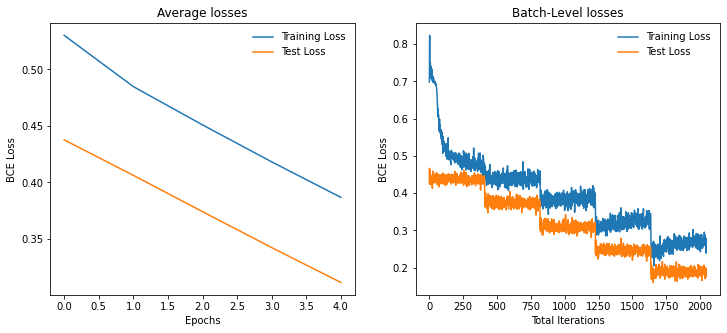

In [ ]:
#Plotting loss vs epochs.
plt.figure(figsize=(12, 5))
ax = plt.subplot(1,2,1)

#First plotting the losses on average of every epoch.
plt.title('Average losses')
plt.xlabel('Epochs')
plt.ylabel('BCE Loss')

plt.plot(train_losses_mean, label='Training Loss')
plt.plot(test_losses_mean, label='Test Loss')
plt.legend(frameon=False);


ax = plt.subplot(1,2,2)

#Also, we'll plot the losses of every iteration of all the epochs.
plt.title('Batch-Level losses')
plt.xlabel('Total Iterations')
plt.ylabel('BCE Loss')

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend(frameon=False);

# Plotting the ROC curve

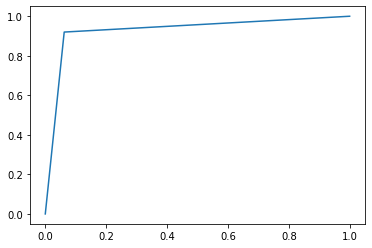

AUC: 92.89%


In [ ]:
from sklearn import metrics

#Getting false and true positive rates of the last predictions.
fpr, tpr, thresholds = metrics.roc_curve(targets, predictions)

#Plot ROC curve
plt.plot(fpr,tpr)
plt.show() 

#Print AUC score
auc = np.trapz(tpr,fpr)
print('AUC: {}%'.format(round(auc*100,2))) 

A few comments about the plots:

In the ROC curve, we can see the expected curve for an AUC score of ~93%, which was also given from the scores in the classification report.

In the Loss vs Epochs, we can see that the loss starts off quite high, but as the epochs progress the loss decreases. Which shows that the model actually improves with each epoch. I chose to plot two variants. The left one shows the curves of the average losses of the train and test sets. Since the curves appeared to be 'too smooth', I decided to plot the losses on each batch of every iteration to show how each epoch affects the datasets.


# Comparison with the Feed Forward GloVe model from Homework 2

A detailed comparison with the model of HW2 can be seen in the ReadMe file (this Notebook is already long enough :)).